In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
import matplotlib.pylab as plt
np.set_printoptions(precision=2)

# Téma: Kalmanův filtr, nelineární filtry

> *It appears that no particular approximate [nonlinear] filter is consistently better than any other, though ... any nonlinear filter is better than a strictly linear one.*
>
> L. Schwartz and E. Stear: "A computational comparison of several nonlinear filters," IEEE Trans. Autom. Control, 1968.

**V reálném světě prakticky není lineárních systémů**

- linearita je zpravidla nanejvýš slušná lokální aproximace,
- ...a to ještě za příznivých podmínek.
    - např. klasické vztahy mezi rychlostí, časem a drahou přestanou platit při vysokých rychlostech (relativistické jevy).
    - např. volt-amperové charakteristiky rezistorů ($I=U/R$) jsou lineární při rozumně nízkých napětích.
- **někdy ani lokální linearita neplatí a musíme sáhnout po nelineárních modelech.**

## Přehled lineárního Kalmanova filtru

**Stavový model a proměnné:**

$$
\begin{align}
x_t &= A_t x_{t-1} + B_t u_t + w_t, &w_t \sim (0, Q_t),\\
y_t &= H_t x_t + \varepsilon_t, &\varepsilon_t \sim (0, R_t).
\end{align}
$$

- $x_t$ neznámý stav
- $y_t$ pozorovaná veličina (měření)
- $w_t\sim (0,Q_t)$ nepozorovaný centrovaný iid šum stavu (procesu) s kovariancí $Q_t$
- $\varepsilon_t \sim (0,R_t)$ nepozorovaný centrovaný iid šum modelu (pozorování, měření) s kovariancí $R_t$
- $u_t$ externí veličina (regresor, vstup, řídící veličina)
- $A_t, B_t, H_t$ - matice odpovídajících rozměrů

---

**Inicializace:** Nastavíme $x_0$ (iniciální odhad stavu) a $P_0^+$ (iniciální kovariance odhadů).

**Pro $t=1,2,\ldots$:**

    - Predikce stavů (časový update)
$$
\begin{align}
\hat{x}_t^{-} &= A_t \hat{x}_{t-1}^{+} + B_t u_t,\\
P_t^{-} &= A_t P_{t-1}^{+} A_t^\intercal + Q_t.
\end{align}
$$

    - Korekce (datový update) stavů pozorováním $y_t$
$$
\begin{aligned}
K_t &= P_{t}^- H_t^\intercal (H_t P_{t}^{-} H_t^\intercal + R_t)^{-1},\\
\hat{x}_t^+ &= \hat{x}_{t}^{-} + K_t(y_t - H_t \hat{x}_{t}^{-}), \\
P_t^{+} &= (I - K_t H_t) P_{t}^{-} (I - K_t H_t)^\intercal + K_t R_t K_t^\intercal.
\end{aligned}
$$

## Příklad

Podíváme se na následující příklad: máme online zašuměná měření polohy objektu na 2D ploše, v osách $(x_1, x_2)$, tj. $x_{1,t}$ a $x_{2,t}$. Tato měření jsou získávána každou jednu sekundu. Cílem je odhadovat polohu filtrovanou od šumu a rychlosti v obou osách. Máme tedy


$$
x_t =
\begin{bmatrix}
x_{1,t} \\ 
x_{2,t} \\ 
v_{x_1,t} \\ 
v_{x_2,t}
\end{bmatrix}
$$

Víme, že pro polohu v první ose platí

$$
x_{1,t} = x_{1,t-1} + v_{x_1,t} dt + w_{x_1,t},
$$

a že analogicky platí totéž i pro polohu v ose druhé. Abychom se nemuseli zaobírat zrychlením, budeme uvažovat, že rychlost je stejná a její změny jsou způsobeny jen šumem,

$$
v_{x_1,t} = v_{x_1, t-1} + w_{vx_1, t}.
$$

Pokud sestavíme odpovídající stavový model

$$
\begin{align}
x_t &= A_t x_{t-1} + B_t u_t + w_t, &w_t \sim (0, Q_t),\\
y_t &= H_t x_t + \varepsilon_t, &\varepsilon_t \sim (0, R_t)
\end{align}
$$

a filtrujeme stavy, dobereme se k výsledku:

![KF](img/kf-tracking.gif)

![KF](img/kf-tracking.png)
![KF](img/kf-rychlost.png)

Teď by byla na řadě analýza reziduí atd. Co ale vidíme z obrázků?

- filtrovaná poloha prochází mezi body. Odchylky od skutečné trajektorie v pokročilejších časových okamžicích jsou kvůli interpolaci šumu s realizacemi na jedné straně trajektorie.
- filtr se na začátku učil (a měl tam v tomto konkrétním případě celkem těžkou situaci).
- odhady rychlostí jsou odchýlené od skutečných rychlostí. To kvůli jednoduchému modelu, kdybychom zahrnuli do modelu zrychlení, bylo by modelování hned lepší.

# Trocha matematiky před nelinaritou...

Předpokládejme, že máme funkci $f(x)$, kterou lze v okolí bodu $a$ rozvinout konvergentní mocninnou řadou:

$$
f(x) = \sum_{n=0}^\infty z_n (x-a)^n.
$$

Takové funkci se říká **analytická**. Pokud bychom uvedený vztah $n$-krát derivovali a položili $x=a$, dostaneme vyjádření pro $z_n$,

$$
z_n = \frac{f^{(n)}(a)}{n!}.
$$

Takové řadě se říká [**Taylorova řada**](https://en.wikipedia.org/wiki/Taylor_series). Umožňuje nám pro $n\to\infty$ psát

$$
\begin{align}
f(x) &= f(a) + f'(a)(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \ldots \\
&= \sum_{n=0}^\infty \frac{f^{(n)}(a)}{n!} (x-a)^n.
\end{align}
$$

Pokud má funkce $f$ v bodě $a$ konečné derivace do konečného řádu $n$, potom mluvíme o **Taylorově polynomu řádu $n$** ve tvaru

$$
\begin{align}
T_n(f, a) &= f(a) + f'(a)(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \ldots + \frac{f^{(n)}(a)}{n!} (x-a)^n \\
&= \sum_{n=0}^n \frac{f^{(n)}(a)}{n!} (x-a)^n.
\end{align}
$$

> [**Taylorova věta**](https://en.wikipedia.org/wiki/Taylor%27s_theorem)
>
> Nechť funkce $f:\mathbb{R}\to\mathbb{R}$ má konečné derivace v bodě $a\in\mathbb{R}$ až do řádu $n+1$. Potom existuje Taylorův polynom řádu $n$ a zbytek $R_{n+1}^{(f,a)}(x)$ ve tvaru
>
>$$
f(x) = f(a) + f'(a)(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \ldots + \frac{f^{(n)}(a)}{n!} (x-a)^n + R_{n+1}^{(f,a)}(x).
$$

Taylorův polynom konverguje v $x$ k hodnotě $f(x)$, právě když $\lim_{n\to\infty} R_{n+1}^{(f,a)}(x)=0$.

### Příklad
Zkusíme několik prvních aproximací funkce $f(x) = e^x$ v okolí bodu $a=0$.

$$f(x) = e^x = 1 + x + \frac{x^2}{2!} + \frac{x^3}{3!} + \ldots$$

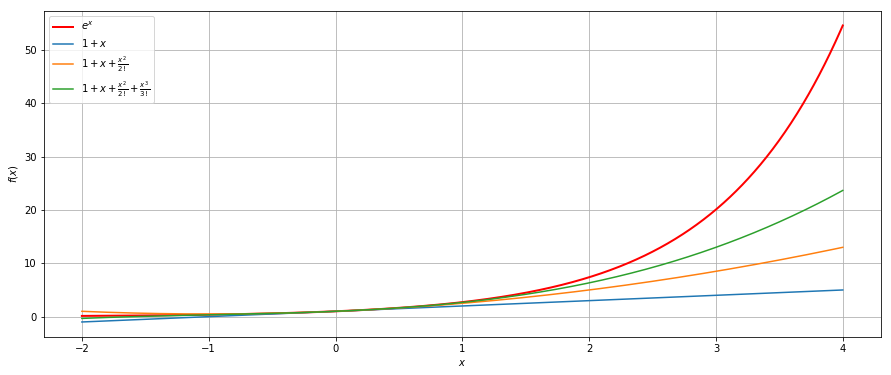

In [11]:
x = np.linspace(-2,4,1000)
plt.figure(figsize=(15,6))
plt.plot(x, np.exp(x), 'r', lw=2, label=r'$e^x$')
plt.plot(x, 1+x, label=r'$1+x$')
plt.plot(x, 1+x+x**2/2, label=r'$1+x+\frac{x^2}{2!}$')
plt.plot(x, 1+x+x**2/2+x**3/6, label=r'$1+x+\frac{x^2}{2!}+\frac{x^3}{3!}$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.legend()
plt.show()

Je dobře patrné, že čím vyšší řád Taylorova polynomu, tím lepší aproximace, zejména v oblastech dále od nuly.

# Rozšířený Kalmanův filtr

Předpokládejme nyní stavový model **s aditivním šumem** ve tvaru

$$
\begin{align}
x_t &= f_t(x_{t-1}, u_t) + w_t, \\
y_t &= h_t(x_t) + \varepsilon_t,
\end{align}
$$

kde $f_t$ a $h_t$ jsou nelineární funkce a ostatní veličiny mají stejné vlastnosti jako v lineárním stavovém modelu. Pokud příslušné funkce mají derivace aspoň prvního řádu, je možné zkusit použít rozšířený [Kalmanův filtr (Extended Kalman Filter, EKF)](https://en.wikipedia.org/wiki/Extended_Kalman_filter). Ten využívá lokální linearizaci pomocí derivace (resp. Taylorova rozvoje).

## Linearizace v modelu s aditivním šumem

Určíme Taylorův rozvoj stavové rovnice okolo bodu $x_{t-1} = \hat{x}_{t-1}^{+}$:

$$
\begin{aligned}
x_t 
&= 
f_t\left(\hat{x}_{t-1}^{+}, u_t\right) +
f_{t}'(\hat{x}_{t-1}^{+})
\left( x_{t-1} - \hat{x}_{t-1}^+\right) +
w_t \\
&=
f_t\left(\hat{x}_{t-1}^{+}, u_t\right) +
F_{t}\left(x_{t-1} - \hat{x}_{t-1}^+\right) +
w_t \\
&=
F_t x_{t-1} + \left[ f_t\left(\hat{x}_{t-1}^{+}, u_t\right) - F_t \hat{x}_{t-1}^+ \right] + w_t \\
&=
F_t x_{t-1} + \tilde{u}_t + w_t.
\end{aligned}
$$

Proměnná $F_t=f_t'(\hat{x}_{t-1}^{+})$ je určena výše a

$$
\begin{aligned}
\tilde{u}_t &= f_t\left(\hat{x}_t^+, u_t\right) - F_t \hat{x}_{t-1}^+.
\end{aligned}
$$

Podobně najdeme Taylorův rozvoj druhé stavové rovnice pro $x_t = \hat{x}_t^-$:

$$
\begin{align}
y_t 
&=
h_t \left(\hat{x}_t^-\right) + h_t'(\hat{x}_t^-) \left( x_t - \hat{x}_t^- \right) + \varepsilon_t \\
&=
h_t \left(\hat{x}_t^-\right) + H_t\left(x_t - \hat{x}_t^- \right) + \varepsilon_t \\
&=
H_t x_t + \left[ h_t \left(\hat{x}_t^-\right) - H_t \hat{x}_t^- \right] + \varepsilon_t \\
&=
H_t x_t + z_t + \varepsilon_t,
\end{align}
$$

kde

$$
\begin{align}
H_t &= h_t'(\hat{x}_t^-), \\
z_t &= h_t \left(\hat{x}_t^-\right) - H_t \hat{x}_t^-.
\end{align}
$$

Máme tedy **linearizovaný stavový model** ve tvaru:

$$
\begin{aligned}
x_t &= F_t x_{t-1} + \tilde{u}_t + {w}_t,\\
y_t &= H_t x_t + z_t + \varepsilon_t,
\end{aligned}
$$

kde všechny příslušné proměnné najdeme výše a který můžeme odhadovat pomocí standardního **lineárního** Kalmanova filtru.

## Algoritmus EKF (aditivní šum)

**Inicializace:** Nastavíme $x_0$ (iniciální odhad stavu) a $P_0^+$ (iniciální kovariance odhadů).

**Pro $t=1,2,\ldots$:**

    - Linearizace pro predikci
$$
\begin{align}
F_t &= f_t'(\hat{x}_{t-1}^+).
\end{align}
$$

    - Predikce stavů (časový update)
$$
\begin{align}
\hat{x}_t^{-} &= f_t(\hat{x}_{t-1}^+, u_t),\\
P_t^{-} &= F_t P_{t-1}^{+} F_t^\intercal + Q_t.
\end{align}
$$

    - Linearizace pro korekci
$$
\begin{align}
H_t &= h_t'(\hat{x}_{t}^-).
\end{align}
$$

    - Korekce (datový update) stavů pozorováním
$$
\begin{aligned}
K_t &= P_{t}^- H_t^\intercal (H_t P_{t}^{-} H_t^\intercal + R_t)^{-1},\\
\hat{x}_t^+ &= \hat{x}_{t}^{-} + K_t\left[y_t - h_t\left(\hat{x}_{t}^{-}\right)\right], \\
P_t^{+} &= (I - K_t H_t) P_{t}^{-} (I - K_t H_t)^\intercal + K_t R_t K_t^\intercal.
\end{aligned}
$$

Za povšimnutí určitě stojí, že bodové odhady stavové veličiny a predikce pozorování získáváme namísto z linearizovaných výrazů rovnou z funkcí stavového modelu. Linearizace nám pomůže zejména pro vývoj kovariancí odhadů stavů.

## Vlastnosti EKF

- odhad EKF obecně není optimální. Optimalita je zajištěna pouze tehdy, pokud jsou stavové funkce lineární - pak se vše ale zredukuje na lineární stavový model a lineární KF.
- EKF může divergovat, zvl. pokud jsou iniciální stavy nastaveny hodně špatně.
- kovarianční matice odhadů je obvykle podhodnocena, čímž může být filtr inkonzistentní.
- pokud není model dostatečně dobře znám nebo je nepřesný, je lepší stejně použít Monte Carlo metody.
- obecně má ale EKF natolik dobré vlastnosti, že je standardem v celé řadě problémů, včetně navigace a GPS.
- v případě potřeby navíc existují vylepšené verze, např. s Taylorovým polynomem druhého řádu. Bohužel s tím ale roste náročnost.

# Doporučená literatura

**Dan Simon: Optimal State Estimation - Kalman, H$_\infty$ and Nonlinear Approaches**

![Simon](img/simon.jpg)

---
---

## Linearizace při obecném šumu (pro zvídavé)

Není-li šum aditivní, tj. model je obecně

$$
\begin{align}
x_t &= f_t(x_{t-1}, u_t, w_t), \\
y_t &= h_t(x_t, \varepsilon_t),
\end{align}
$$

postupujeme podobně jako výše, jen musíme trochu více linearizovat. Určíme Taylorův rozvoj stavové rovnice okolo bodu $x_{t-1} = \hat{x}_{t-1}^{+}$ a $w_t=0$:

$$
\begin{aligned}
x_t 
&= 
f_t\left(\hat{x}_{t-1}^{+}, u_t, 0\right) +
\frac{\partial f_{t}}{\partial x} \bigg|_{\hat{x}_{t-1}^{+}}
\left( x_{t-1} - \hat{x}_{t-1}^+\right) +
\frac{\partial f_{t}}{\partial w} \bigg|_{\hat{x}_{t-1}^{+}} w_t \\
&=
f_t\left(\hat{x}_{t-1}^{+}, u_t, 0\right) +
F_{t}\left(x_{t-1} - \hat{x}_{t-1}^+\right) +
L_t w_t \\
&=
F_t x_{t-1} + \left[ f_t\left(\hat{x}_{t-1}^{+}, u_t, 0\right) - F_t \hat{x}_{t-1}^+ \right] + L_t w_t \\
&=
F_t x_{t-1} + \tilde{u}_t + \tilde{w}_t.
\end{aligned}
$$

Veličiny $F_t$ a $L_t$ jsou určeny v rovnicích výše a

$$
\begin{aligned}
\tilde{u}_t &= f_t\left(\hat{x}_t^+, u_t, 0\right) - F_t \hat{x}_t^+, \\
\tilde{w}_t &\sim (0, L_t Q_t L_t^\intercal).
\end{aligned}
$$

Máme tedy **linearizovaný stavový model** ve tvaru:

$$
\begin{aligned}
x_t &= F_t x_{t-1} + \tilde{u}_t + \tilde{w}_t,\\
y_t &= H_t x_t + z_t + \tilde{\varepsilon}_t,
\end{aligned}
$$

kde všechny příslušné proměnné najdeme výše a který můžeme odhadovat pomocí standardního **lineárního** Kalmanova filtru.

## Algoritmus EKF

**Inicializace:** Nastavíme $x_0$ (iniciální odhad stavu) a $P_0^+$ (iniciální kovariance odhadů).

**Pro $t=1,2,\ldots$:**

    - Linearizace pro predikci
$$
\begin{align}
F_t &= \frac{\partial f_t}{\partial x}\bigg|_{\hat{x}_{t-1}^+},\\
L_t &= \frac{\partial f_t}{\partial w}\bigg|_{\hat{x}_{t-1}^+}
\end{align}
$$

    - Predikce stavů (časový update)
$$
\begin{align}
\hat{x}_t^{-} &= f_t(\hat{x}_{t-1}^+, u_t, 0),\\
P_t^{-} &= F_t P_{t-1}^{+} F_t^\intercal + L_t Q_t L_t^\intercal.
\end{align}
$$

    - Linearizace pro korekci
$$
\begin{align}
H_t &= \frac{\partial h_t}{\partial x}\bigg|_{\hat{x}_{t}^-},\\
M_t &= \frac{\partial h_t}{\partial \varepsilon}\bigg|_{\hat{x}_{t}^-}
\end{align}
$$

    - Korekce (datový update) stavů pozorováním
$$
\begin{aligned}
K_t &= P_{t}^- H_t^\intercal (H_t P_{t}^{-} H_t^\intercal + M_t R_t M_t^\intercal)^{-1},\\
\hat{x}_t^+ &= \hat{x}_{t}^{-} + K_t\left[y_t - h_t\left(\hat{x}_{t}^{-},0\right)\right], \\
P_t^{+} &= (I - K_t H_t) P_{t}^{-} (I - K_t H_t)^\intercal + K_t R_t K_t^\intercal.
\end{aligned}
$$